LLM Final Assesment

##**Employee Sentiment Analysis**

In [4]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from datetime import timedelta


In [175]:
# Load Dataset
df = pd.read_excel('test.xlsx')

In [176]:
df.head() # to see first five rows of dataset

,Subject,body,date,from
0,EnronOptions Update!,"EnronOptions Announcement\n\n\nWe have updated the EnronOptions =01) Your Stock Option Program web site! =\nThe=20\nweb site now contains specific details of the EnronOptions Program includin=\ng=20\nthe December 29, 2000 grant price and additional information on employee=20\neligibility.\n\nAccess EnronOptions =01) Your Stock Option Program web site by clicking on=\n=20\nhttp://hrweb.enron.com or by typing the address into your web browser.\n\nWe hope you find the revised site helpful in addressing your questions abou=\nt=20\nthe EnronOptions Program. If you have any additional questions, please=20\ncontact your H.R. Representative.\n\nStay tuned for more information throughout March and April 2001.",2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to work for the revenue model for mid & \nback office services meeting. How about this coming Monday, Feb 26 from 1:00 \n- 2:30 pm? I have penciled in that time for Sally, Mary Solmonson & James \nScribner. Please let me know if that will work for you.\n\nThanks,\nPatti x39106",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 AM (GMT-06:00) Central Time (US & Canada).\nWhere: @ 10:00am CST (225) 931-8111\n\n*~*~*~*~*~*~*~*~*~*\n\n",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewhere closer to you this time) \nagain at around 8\n\n\n\n\nJason Bass <JBass@stdauto.com> on 02/21/2001 11:22:45 AM\n,2010-03-25,johnny.palmer@enron.com
4,Bet,"Since you never gave me the $20 for the last time we bet on CU/Texas, I figured I would give you the chance to go double or nothing on the second round. I think the line is Texas -9. Let me know.",2011-05-21,lydia.delgado@enron.com


In [177]:
df['from'].value_counts() # There are total of 10 Employees

,count
from,
lydia.delgado@enron.com,284
john.arnold@enron.com,256
sally.beck@enron.com,227
patti.thompson@enron.com,225
bobette.riner@ipgdirect.com,217
don.baughman@enron.com,213
johnny.palmer@enron.com,213
eric.bass@enron.com,210
kayne.coulter@enron.com,174


In [178]:
df.describe(include='all')
# Observation:
# - 21 rows in 'body' contain only newline characters (\n\n).
# - 141 rows in 'subject' contain "No Subject".
# - Majority of emails were sent in the year 2011.

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,NaN,10
top,(No Subject),\n\n,NaN,lydia.delgado@enron.com
freq,141,21,NaN,284
mean,NaN,NaN,2010-12-31 02:17:21.716111360,NaN
min,NaN,NaN,2010-01-01 00:00:00,NaN
25%,NaN,NaN,2010-06-30 12:00:00,NaN
50%,NaN,NaN,2011-01-01 00:00:00,NaN
75%,NaN,NaN,2011-06-30 12:00:00,NaN
max,NaN,NaN,2011-12-31 00:00:00,NaN


In [179]:
df_filtered = df[df['body'].str.strip() != ''].copy()

In [180]:
# Remove email bodies with very few words, as they lack meaningful content for sentiment analysis
df_filtered=df_filtered[df_filtered['body'].apply(lambda x: len(str(x).split()))>2]

In [181]:
df_filtered

,Subject,body,date,from
0,EnronOptions Update!,"EnronOptions Announcement\n\n\nWe have updated the EnronOptions =01) Your Stock Option Program web site! =\nThe=20\nweb site now contains specific details of the EnronOptions Program includin=\ng=20\nthe December 29, 2000 grant price and additional information on employee=20\neligibility.\n\nAccess EnronOptions =01) Your Stock Option Program web site by clicking on=\n=20\nhttp://hrweb.enron.com or by typing the address into your web browser.\n\nWe hope you find the revised site helpful in addressing your questions abou=\nt=20\nthe EnronOptions Program. If you have any additional questions, please=20\ncontact your H.R. Representative.\n\nStay tuned for more information throughout March and April 2001.",2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to work for the revenue model for mid & \nback office services meeting. How about this coming Monday, Feb 26 from 1:00 \n- 2:30 pm? I have penciled in that time for Sally, Mary Solmonson & James \nScribner. Please let me know if that will work for you.\n\nThanks,\nPatti x39106",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 AM (GMT-06:00) Central Time (US & Canada).\nWhere: @ 10:00am CST (225) 931-8111\n\n*~*~*~*~*~*~*~*~*~*\n\n",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewhere closer to you this time) \nagain at around 8\n\n\n\n\nJason Bass <JBass@stdauto.com> on 02/21/2001 11:22:45 AM\n,2010-03-25,johnny.palmer@enron.com
4,Bet,"Since you never gave me the $20 for the last time we bet on CU/Texas, I figured I would give you the chance to go double or nothing on the second round. I think the line is Texas -9. Let me know.",2011-05-21,lydia.delgado@enron.com
...,...,...,...,...
2186,Re: Resume,Thanks for the resume. She has had some good experience. Do you know much \nabout her performance here at Enron? Can I call and talk with her directly? \nI would certainly keep the conversation confidential at this point. --Sally \n\n\n\n\nVince J Kaminski\n11/21/2000 08:14 AM\n,2011-06-17,johnny.palmer@enron.com
2187,"Final Schedule - Wednesday, May 2, 2001 - Jesus O. Guerra","Attached please find the following documents:\n\n\n \n\n\nThanks,\nLydia\n\nx3-9338",2011-01-20,johnny.palmer@enron.com
2188,(No Subject),"Good to finally hear from. Judging from your e-mail, it sounds like you had \nsome fun in your exercises- I guess that English degree is finally paying off.\nLuckily you missed out on another series of disappointments from the Longhorn \nfootball team. It seems as though they are improving, however. Hopefully we \nwill be playing for the National Championship next year. \n\nHow are things otherwise? When are you coming into town again?\n\nLater-\n\nEric",2011-01-02,don.baughman@enron.com
2189,League is Set,"It looks like we have our 12 teams. We will probably keep the same rules \nfrom last year unless anybody has an objection. Still to be determined are \nleague fees, draft date , and free agent pickup protocol. I suggest that we \ndraft on August 27th at the Enron building on floor 26. For those of you \nthat can't make it, you can draft over the internet. We will be using cbs \nsportsline again - I think that will be $8/person.\n\nLet me know if anyone has a problem with the draft date, i.e. can't make it, \ntoo early, too late.\nIf not, THE MEXIMULLETS look forward to a return to Prominence this year. \nYou all do not stand a chance!\n\n-Eric",2011-03-11,rhonda.denton@enron.com


In [182]:
# remove whitespaces and convert text to lowercase for consistent processing, ensuring that words like "Hello" and " hello " are treated the same.
df_filtered['body'] = df_filtered['body'].str.lower().str.strip()
df_filtered['Subject'] = df_filtered['Subject'].str.lower().str.strip()
df_filtered['from'] = df_filtered['from'].str.lower().str.strip()

In [183]:
# Get the first 30 rows of email body for testing sentiment analysis
# texts=df_filtered['body'].head(30)

### Testing Sentiment Analysis techniques

In [184]:
# --- TextBlob Sentiment Analysis on top 30 Email bodies ---

# def get_textblob_label(polarity):
#     if polarity > 0:
#         return "Positive"
#     elif polarity < 0:
#         return "Negative"
#     else:
#         return "Neutral"

# for i, text in enumerate(texts):
#     blob = TextBlob(text)
#     polarity = blob.sentiment.polarity
#     label = get_textblob_label(polarity)

#     print(f"\nText {i+1}: {text}")
#     print(f"  Polarity: {polarity}")
#     print(f"  Sentiment: {label}")




```
# Observation:
TextBlob gets too negative about certain words.
For example, if a message says "Unfortunately, today won't work for the meeting," TextBlob sees the word "unfortunately" and thinks the whole message is negative — even though it's just about rescheduling.
```



In [185]:
# --- VADER Sentiment Analysis on top 30 rows of Email bodies ---

# def get_vader_label(compound):
#     if compound >= 0.05:
#         return "Positive"
#     elif compound <= -0.05:
#         return "Negative"
#     else:
#         return "Neutral"

# analyzer = SentimentIntensityAnalyzer()

# for i, text in enumerate(texts):
#     scores = analyzer.polarity_scores(text)
#     compound = scores['compound']
#     label = get_vader_label(compound)

#     print(f"\nText {i+1}: {text}")
#     print(f"  Compound: {compound}")
#     print(f"  Sentiment: {label}")




```
# Observation:
VADER often mistakes polite or formal business language as being positive.
For example, if a message says, "We hope you find the site helpful," VADER thinks it's happy or cheerful, even though it's just a polite, neutral sentence.
```



In [186]:
# --- nlptown on top 30 rows of email body ---

# Load NLPtown model
# nlptown_model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
# nlptown_tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [187]:

# def predict_nlptown(text):
    # tokens = nlptown_tokenizer(text, return_tensors='pt', truncation=True)
    # output = nlptown_model(**tokens)
    # probs = torch.nn.functional.softmax(output.logits, dim=1)
    # label = torch.argmax(probs).item()
    # Mapping 1-2: Negative, 3: Neutral, 4-5: Positive
    # if label <= 2:
        # sentiment = 'Negative'
    # elif label == 3:
        # sentiment = 'Neutral'
    # else:
        # sentiment = 'Positive'
    # return sentiment


In [188]:
# for i, text in enumerate(texts):
#  label=predict_sentiment(str(text))
#  print('Text:\n',text,'\n')
#  print("Sentiment:",label)




```
 # Observation
 Performed well but Slightly slower due to larger head
```



In [189]:
# ---BERT cardiffnlp on top 30 rows of Email Bodies---

# Load the BERT cardiffnlp model and tokenizer
tokenizer = AutoTokenizer.from_pretrained( "cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained( "cardiffnlp/twitter-roberta-base-sentiment")

In [190]:
# BERT (CardiffNLP) Function to predict sentiment from text
def predict_sentiment(text):
    # Tokenize the input text and prepare tensors for the model
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Disable gradient calculations (we're not training here)
    with torch.no_grad():
        outputs = model(**tokens)  # Get raw scores (logits) from the model

    # Convert logits to probabilities using softmax
    prob = torch.nn.functional.softmax(outputs.logits, dim=1)

    # Get the index of the highest probability
    predicted = torch.argmax(prob).item()

    # Map the predicted index to a sentiment label
    if predicted == 0:       # If index is 0 → Negative has the highest score
        return 'negative'
    elif predicted == 1:     # If index is 1 → Neutral has the highest score
        return 'neutral'
    else:                    # If index is 2 → Positive has the highest score
        return 'positive'


In [191]:
# for i, text in enumerate(texts):
  # label=predict_sentiment(str(text))
  # print('Text:\n',text,'\n')
  # print("Sentiment:",label)




```
# Observation:
It avoids classifying professional emails as "positive" just because they use polite language.
BERT outperformed other models and was selected as the final sentiment analysis tool.
It performed similarly to nlptown but was lighter and faster, making it more efficient.
```



Choosed BERT cardiff model

###Sentiment Labeling with Bert cardiffnlp Model

In [192]:
# Applying BERT cardiffnlp (the selected technique) to the email body for sentiment prediction
df_filtered['Sentiments']=df_filtered['body'].apply(predict_sentiment)

###EDA

In [193]:
# Convert 'date' column to datetime so we can filter, sort, and extract parts like month/year
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

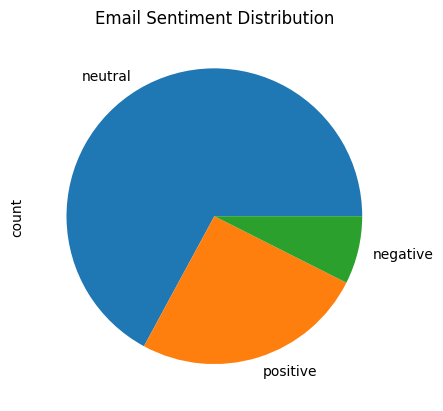

In [194]:
# Email Sentiment Distribution
df_filtered['Sentiments'].value_counts().plot(kind='pie', title='Email Sentiment Distribution')
plt.savefig('email sentiment.png')
plt.show()

```
# observation:
# Most emails have a neutral tone, which is expected in professional communication.
# Low number of negative emails may indicate generally positive work culture.
# The dataset contains mostly neutral sentiments, which may lead to bias in the model — making it predict neutral more often.
```

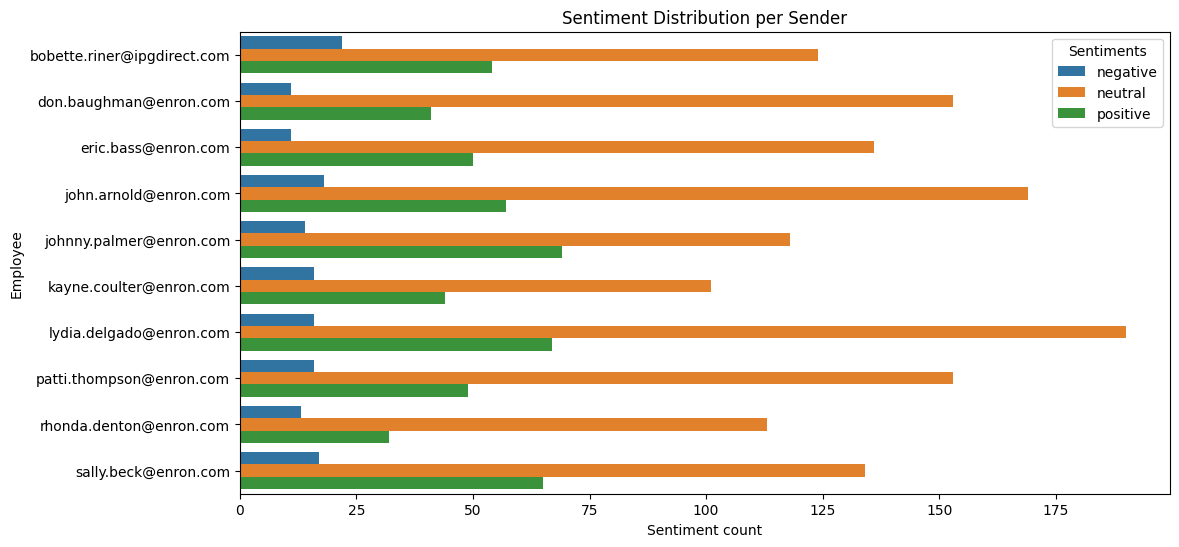

In [195]:
# Group by sender and sentiment
sentiment_counts = df_filtered.groupby(['from', 'Sentiments']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
# Sentiment Distribution per Sender Plot
sns.barplot(data=sentiment_counts, x='count', y='from', hue='Sentiments')
plt.ylabel('Employee')
plt.xlabel('Sentiment count')
plt.title('Sentiment Distribution per Sender')
plt.savefig('Sentiment Distribution per Sender.png')
plt.show()




```
# observation:
# Most employees send neutral-toned emails, suggesting formal communication
# lydia delgado sent a remarkably high number of neutral emails (~200), possibly indicating a coordination or reporting role.
# Bobette Riner sent the most negative emails, possibly indicating a role that involves handling challenging situations or giving feedback.
```



Creating New Features

In [196]:
# We create `message_length` and `word_count` features to capture how long and detailed each email is.
# These features may help identify patterns in sentiment.
df_filtered['message_length'] = df_filtered['body'].apply(lambda x: len(str(x)))
df_filtered['word_count'] = df_filtered['body'].apply(lambda x: len(str(x).split()))

In [197]:
# We extract year_month from the date to analyze emails by month.
# This helps us track sentiment trends over time and see how employee communication changes month to month.
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

In [198]:
# This counts how many emails each person sent every month.
# It helps us see who was more active and when.
# can be useful for spotting communication patterns.
monthly_message_freq = df_filtered.groupby(['from', 'year_month']).size().reset_index(name='message_count')

In [199]:
# Merge monthly email count to our main dataframe.
df_filtered = df_filtered.merge(monthly_message_freq, on=['from', 'year_month'], how='left')

In [200]:
# This stores how long each subject line is.
# It helps us see if longer or shorter subject lines relate to different sentiments.
df_filtered['subject_length'] = df_filtered['Subject'].apply(lambda x: len(str(x)))

Outliers and skewness

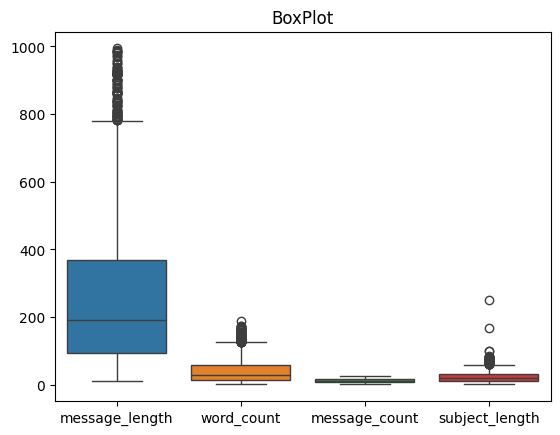

In [201]:
# We check for outliers to identify unusually high or low values that can distort analysis.
sns.boxplot(data=df_filtered[['message_length','word_count','message_count','subject_length']])
plt.title('BoxPlot')
plt.show()

```
# Obsevation
# message_length, subject_length, word_count has outliers
```



In [202]:
# Check skewness to see if features are right- or left-skewed. Skewed data can affect model performance, especially for linear models.
df_filtered[['message_length','word_count','message_count','subject_length']].skew()


,0
message_length,1.208146
word_count,1.284247
message_count,0.215671
subject_length,2.485397




```

# observation:
# message_length, subject_length and word_count are Right-skewed, message_count is roughly symmetrical
```





```
# We compared square root, log, and log1p. Square root can not handles strong skewed, and log1p is good for data with zeros but slightly flattens small values like 2 or 3.
# Since our data has no zeros but includes small values and outliers, log(x) reduces skewness most effectively without flattening small values.
```



In [ ]:
# transform to reduce skewness
df_filtered['message_length'] = np.log(df_filtered['message_length'])
df_filtered['word_count'] = np.log(df_filtered['word_count'])
df_filtered['subject_length'] = np.log(df_filtered['subject_length'])

### Employee Sentiment Scoring and monthly scores

In [233]:
# Assigning sentiment score
df_filtered['sentiment_score'] = df_filtered['Sentiments'].map({'positive': 1,'neutral': 0,'negative': -1})

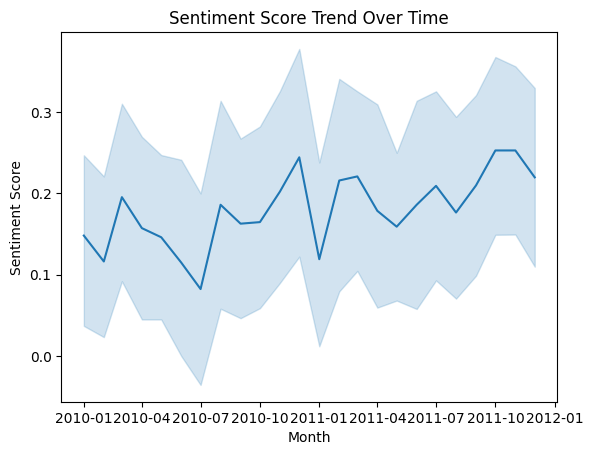

In [234]:
sns.lineplot(x=df_filtered['year_month'].dt.to_timestamp(), y=df_filtered['sentiment_score'])
plt.title("Sentiment Score Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.show()

# Sentiment Score Trend Over Time



```
# observation
The plot reveals a generally increasing trend in employee sentiment scores from early 2010 to late 2011, suggesting improvements in employee engagement over time. A spike in variance during early 2011 indicates inconsistent sentiment (possibly due to internal events), followed by stabilization. These insights support the inclusion of time-based features in predictive modeling and highlight the potential for time series forecasting.

```



In [235]:
# Calculate total sentiment score per employee per month
monthly_scores = (
    df_filtered
    .groupby(['from', 'year_month'])['sentiment_score']  # Group by sender and month
    .sum()  # Sum sentiment scores for that period
    .reset_index()  # Convert grouped data back to a DataFrame
    .rename(columns={'from': 'employee', 'sentiment_score': 'monthly_sentiment_score'})  # Rename columns for clarity
)


In [236]:
# Get the top 3 employees with the highest positive sentiment score each month
top3_positive = (
    monthly_scores
    .sort_values(['year_month', 'monthly_sentiment_score'], ascending=[True, False])  # Sort by month (ascending) and score (descending)
    .groupby('year_month')  # Group by month
    .head(3)  # Take top 3 employees for each month
    .sort_values(['year_month', 'employee'])  # Sort by month and employee
)


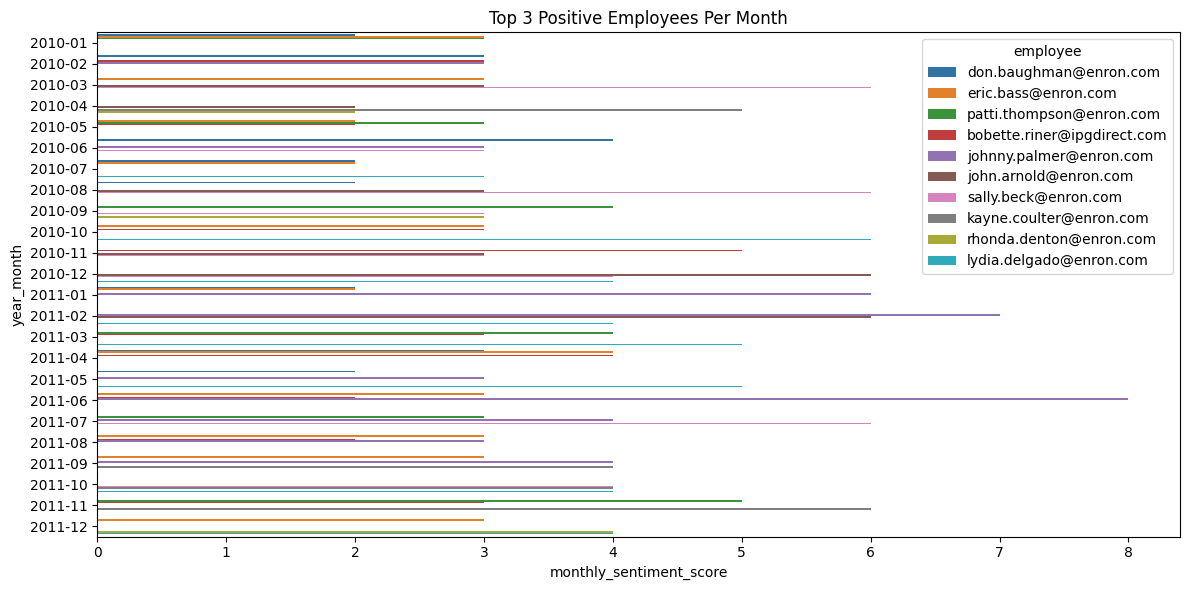

In [237]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top3_positive, x='monthly_sentiment_score', y='year_month', hue='employee')
plt.title("Top 3 Positive Employees Per Month")
plt.tight_layout()
plt.show()



```
Observation:
Who stood out: Johnny Palmer, John Arnold and Sally Beck kept showing up as top performers month after month.
Patterns: Late 2010 and early 2011 show clusters of strong positivity, hinting at improved team spirit, or successful beginnings.

```



In [238]:
# Get the top 3 employees with the most negative sentiment score each month
top3_negative = (
    monthly_scores
    .sort_values(['year_month', 'monthly_sentiment_score'], ascending=[True, True])  # Sort by month (ascending) and score (ascending)
    .groupby('year_month')  # Group by month
    .head(3)  # Take top 3 employees
    .sort_values(['year_month', 'employee'])  # Sort by month and employee
)


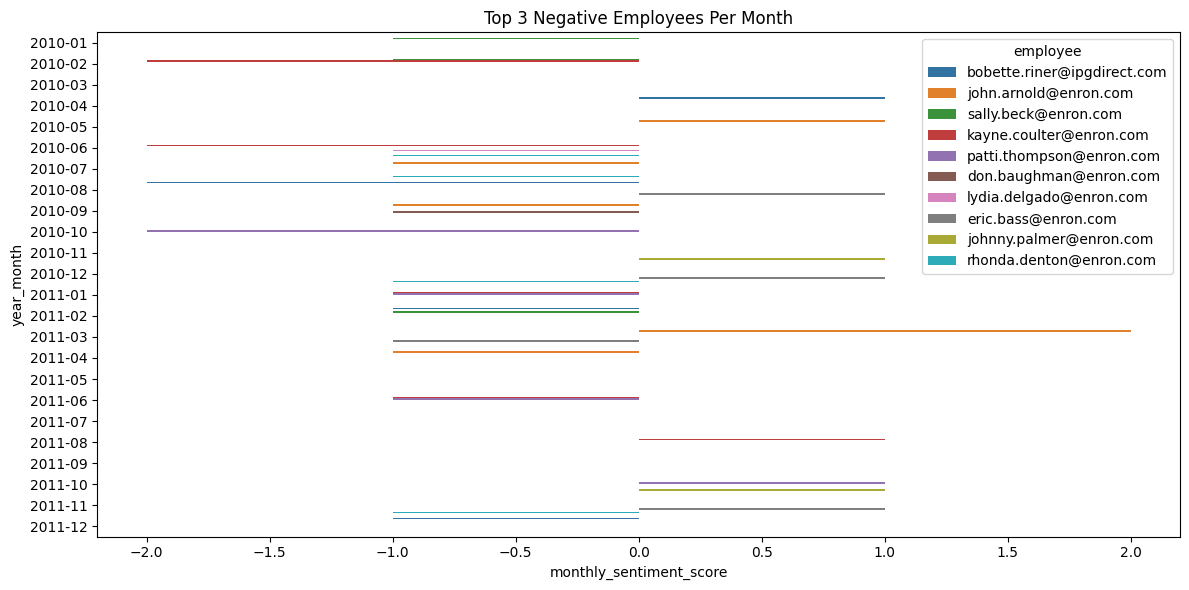

In [239]:
plt.figure(figsize=(12, 6))
sns.barplot(data=top3_negative, x='monthly_sentiment_score', y='year_month', hue='employee')
plt.title("Top 3 Negative Employees Per Month")
plt.tight_layout()
plt.show()



```
Observation:
Bobette Riner, John Arnold, and Rhonda Denton pop up in multiple months, hints that they might have roles involving tough conversations.
Patterns: Mid 2010 to early 2011 stands out with the most frequent negative sentiment scores among top employees. This could be due to increased workload.

```



###Flight Risk Identification

In [240]:
# Create an empty list to store employees who may be at flight risk
flight_risk_employees = []

# Group emails with negative sentiment by sender (employee)
for emp, group in df_filtered[df_filtered['Sentiments'] == 'negative'].groupby('from'):
    # Convert to datetime, sort by date, and reset index
    dates = pd.to_datetime(group['date']).sort_values().reset_index(drop=True)

    for i in range(len(dates)):
        # Check how many negative emails fall within a 30-day window from the current date
        within_30_days = ((dates - dates[i]) <= timedelta(days=30)) & ((dates - dates[i]) >= timedelta(0))

        if within_30_days.sum() >= 4:  # If 4 or more negative emails in 30 days
            flight_risk_employees.append(emp)  # Add employee to risk list
            break  # No need to check further for this employee


In [241]:
# print employees at risk
if flight_risk_employees:
    print("🚨 Flight Risk Employees:")
    for emp in flight_risk_employees:
        print(emp)
else:
    print("✅ No employees at risk.")



🚨 Flight Risk Employees:
bobette.riner@ipgdirect.com
rhonda.denton@enron.com
sally.beck@enron.com


```
# Output:
1. bobette.riner@ipgdirect.com
2. rhonda.denton@enron.com
```



###Predict Sentiment Score

In [242]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Feature Selection

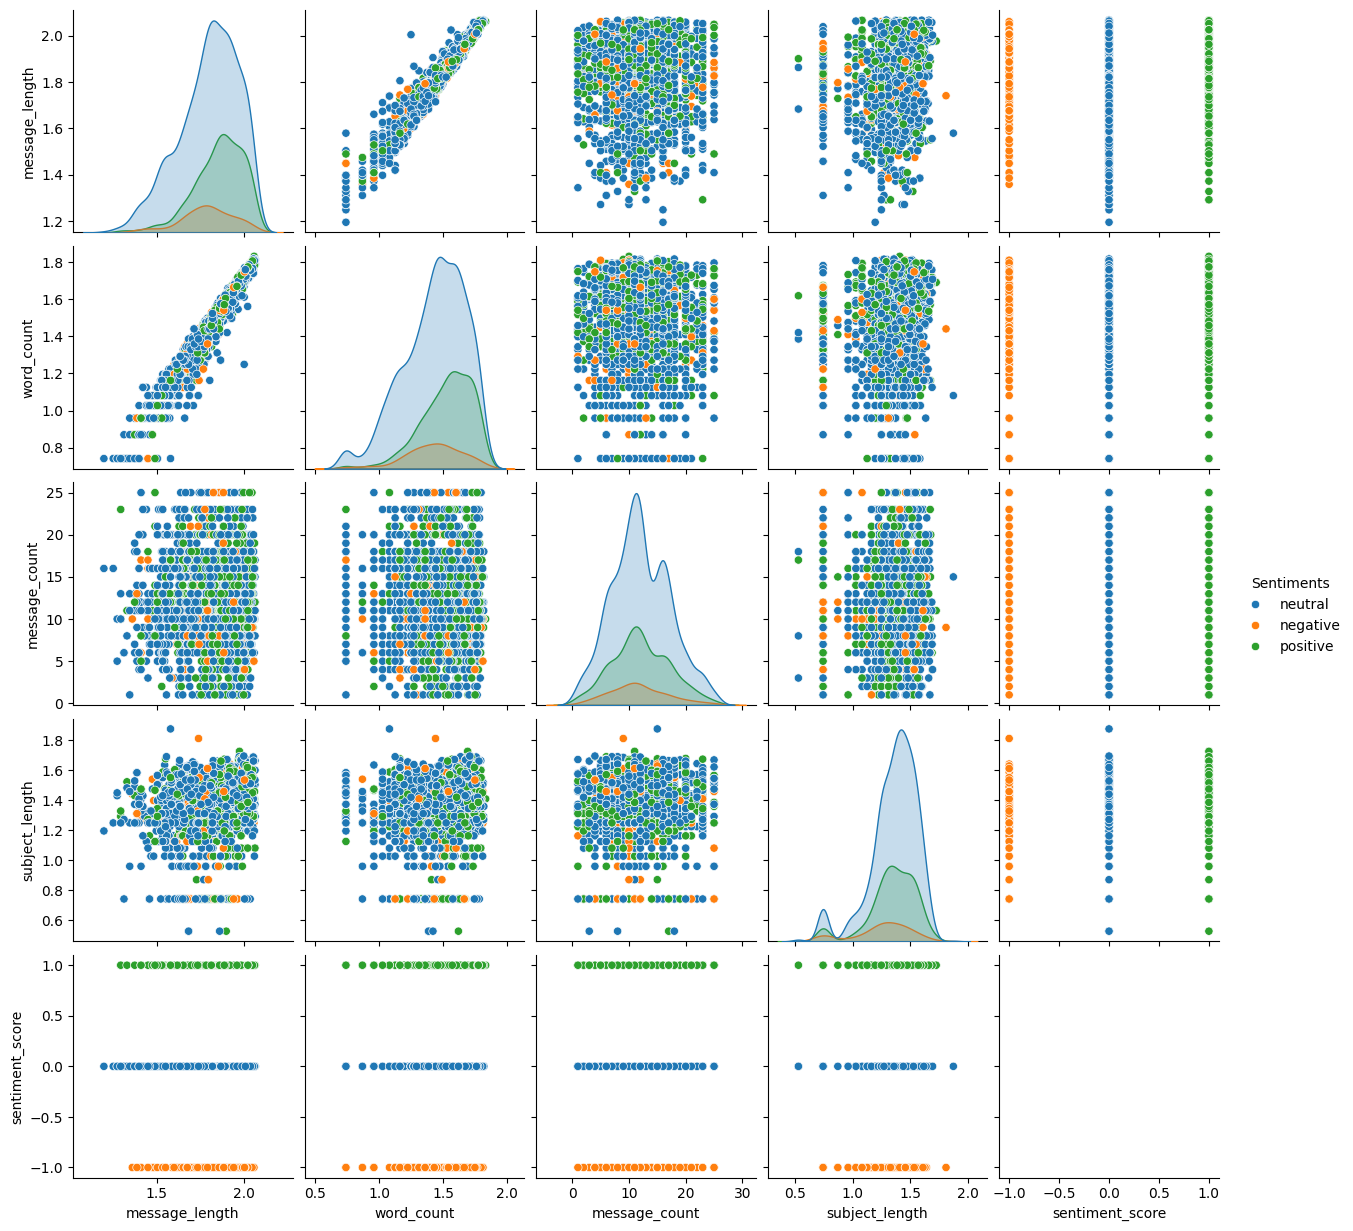

In [243]:
# Pairplot of Email features
sns.pairplot(data=df_filtered,hue='Sentiments' ,diag_kind='kde')



```
Pairplot Insights for Predictive Modeling:
 From the scatter matrix:
- Positive sentiment messages tend to be longer in both character (`message_length`), (`subject_length`) and (`word_count`), suggesting verbosity is associated with positivity.
- Negative sentiment messages are shorter and less detailed.
- There is a strong correlation between `message_length` and `word_count`, which may indicate feature redundancy.
- Message_count shows little to no visible correlation with sentiment class, suggesting it may not be a strong predictive feature.
Conclusion: These insights guide feature selection in the regression model, where we will prioritize message_length, subject_length and word_count while being cautious about multicollinearity.
```



In [244]:
# relationship between features

corr=df_filtered[['message_length','subject_length','message_count','word_count','sentiment_score']].corr()

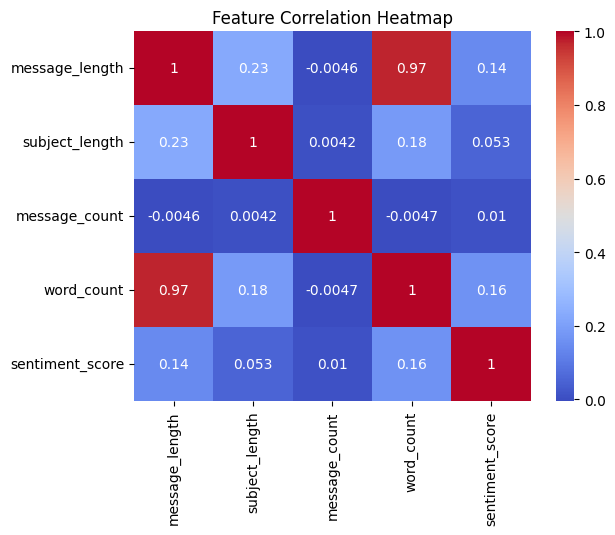

In [245]:
# Analyze relationships between features  to detect patterns, multicollinearity to help us choose the most useful variables for building accurate models.

sns.heatmap(data=corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



```
Observations:
1. message_length and word_count show a high positive correlation, indicating potential multicollinearity. To avoid redundancy and improve model interpretability, one of them should be removed.
2. message_count shows weak correlation with other features, suggesting it may not contribute meaningfully to predicting the sentiment score.

```



In [246]:
# selected features
x=df_filtered[['message_length','subject_length']]

In [247]:
# Target variable
y=df_filtered['sentiment_score']

Text Normalization and TF-IDF Encoding

In [248]:
# We clean and lemmatize text to remove unnecessary words and convert words to their base form, which makes data more useful for model training.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

def clean_and_lemmatize(text):
    tokens = word_tokenize(str(text))  # tokenize the text
    cleaned = [
        lemmatizer.lemmatize(token) # # Convert word to its base form
        for token in tokens
        if token.isalnum() and token not in stop_words  # Keep only alphanumeric & non-stopwords
    ]
    return ' '.join(cleaned)

In [249]:
# apply function to preprocess text
df_filtered['body_cleaned'] = df_filtered['body'].apply(clean_and_lemmatize)



```
I used TF-IDF to turn text into numbers. It gives more importance to rare, useful words and less to common words.
I didn’t use CountVectorizer because it treats all words equally.
Since my dataset is small, TF-IDF was a better choice.
```



In [250]:
# Apply TF-IDF vectorization to the cleaned email body to convert text into numerical features
vectorizer = TfidfVectorizer(max_features=500)  # Limit to top 500 features
tfidf_matrix = vectorizer.fit_transform(df_filtered['body_cleaned'])  # Transform the cleaned text

# Convert the TF-IDF matrix into a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())


In [251]:
# Join TF-IDF Dataframe with selected features
df_final = pd.concat([x.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

Feature Scaling



```
Although the features were already transformed using log to reduce skewness and bring them to a similar range, I still applied Scaling because Linear Regression is sensitive to feature scales, and my data had outliers.
```





```
I chose RobustScaler because my data had outliers and was not evenly spread. It uses the median and IQR,
so it's less affected by extreme values.
In comparison, StandardScaler uses the mean, and MinMaxScaler
uses the min and max, which makes them more sensitive to outliers.
```



In [252]:
robust_scaler = RobustScaler()

In [253]:
# Apply RobustScaler to message_length and subject_length
df_final[['message_length', 'subject_length']] = robust_scaler.fit_transform(df_final[['message_length','subject_length']])


Train model

In [254]:
model=LinearRegression()

In [255]:
# We use train_test_split to divide data into training and testing sets that helps evaluate how well the model performs on unseen data.
X_train, X_test, y_train, y_test = train_test_split(df_final,y, test_size=0.2, random_state=42)

In [256]:
# We train the model to learn patterns from the data, so it can make predictions.
model.fit(X_train, y_train)

LinearRegression()

Predict and Evaluate

In [257]:
# We apply the trained model on test data to see how well the model can make accurate predictions.
predictions = model.predict(X_test)



```
We used MAE because it's robust to outliers and gives average prediction error.
RMSE to evaluate how large errors behave.
R² score was used to see how well our model explains variation in sentiment.
```



In [ ]:
# We evaluate the model to measure how well it performs on unseen data.
print("MAE:", mean_absolute_error(y_test, predictions))
print("R² Score:", r2_score(y_test, predictions))
print("RMSE:", root_mean_squared_error(y_test, predictions))



```
# Output:
MAE: 0.31578595304951473
R² Score: 0.30347734675791616
RMSE: 0.4299519394580362
```





```
# observation
A low MAE (0.31) and RMSE (0.43) show that predictions are close to actual sentiment scores,
and the R² score (0.30) means the model explains 30% of the variance in sentiment.
```





```
Even though we used evaluation metrics like RMSE, R² score, and MAE to measure model performance numerically, we also used a scatter plot of Actual vs. Predicted Sentiment Scores to know whether the model struggles more with certain sentiment classes (e.g., -1 or 1)

```



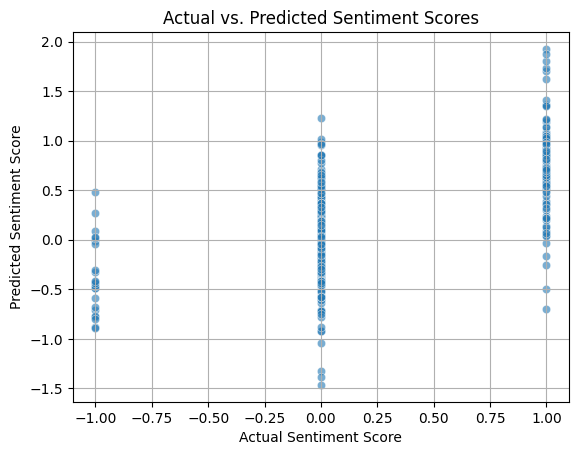

In [259]:
# Actual vs Predicted Sentiment Scores Plot
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.xlabel('Actual Sentiment Score')
plt.ylabel('Predicted Sentiment Score')
plt.title('Actual vs. Predicted Sentiment Scores')
plt.grid(True)
plt.show()



```
# observation:
The model struggles most with negative sentiments (predictions are farther from -1).
It performs better for positive sentiments, predicting scores closer to +1.
Neutral predictions are predicted fairly well.
```



Conclusion:
Over the span of two years, we looked into employee emails and noticed that most of them carried a neutral tone—something you’d expect in a professional setting. Over time, sentiment trends showed a general rise, with some emotional spikes around early 2011, hinting at possible internal events. Positive emails tended to be longer and more expressive, while negative ones were short and to the point. After cleaning the data and handling outliers, we used a linear regression model to predict sentiment scores. The model did a decent job, particularly with neutral emails, since they made up most of the dataset. Altogether, this analysis gave us a clearer view of how employees communicated and how their tone shifted over time.